In [ ]:
"""
Hybrid HMM + Feed-Forward‑MDN packet generator
====================================================

  1.  bootstrap a small GMM‑HMM to learn the discrete state backbone;
  2.  compute state posteriors γₜ,ₖ for every packet;
  3.  train **one** feed‑forward MDN that takes a *one‑hot(state)* and outputs
     a mixture of Gaussians for `(payload_log_z, dt_z)`;
  4.  (optional) refine the transition matrix with a single EM step;
  5.  generate one synthetic flow per test‑flow length using the HMM to sample
     states and the MDN to sample emissions.
"""

# =============================================================================
# 0  Imports, RNG, paths
# =============================================================================
from pathlib import Path
import random, math, itertools, time

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from hmmlearn import hmm
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RAW_PATH   = Path('real_data/df_raw_HTTP.csv')
MODELS_DIR = Path('models')
DATA_DIR   = Path('synth_data')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True,  exist_ok=True)

# =============================================================================
# 1  Load & pre‑process packets
# =============================================================================
print('\u25ba  Reading raw packets …')
df = pd.read_csv(
    RAW_PATH,
    usecols=['flow_id', 'payload_length', 'time_diff']
)

# basic cleaning
_df_invalid = (~np.isfinite(df['payload_length'])) | (~np.isfinite(df['time_diff']))
if _df_invalid.any():
    print(f'   ! dropping {_df_invalid.sum()} rows with non‑finite values')
    df = df[~_df_invalid]

# physical bounds & missing
df['payload_length'] = df['payload_length'].clip(lower=0).fillna(0)
df['time_diff']      = df['time_diff'].clip(lower=0).fillna(0)

# log‑transform payload so we can model support (0, +∞)
df['payload_log'] = np.log1p(df['payload_length'])
# Get rid of rows that has time_diff > 25 miliseconds
df = df[df['time_diff'] < 25e-3] 

# columns to be modelled (before z‑score)
cols_raw = ['payload_log', 'time_diff']

# -----------------------------------------------------------------------------
# 1.1   train / test split (by *flow*, never by packet)
flow_ids          = df['flow_id'].unique()
train_flows, test_flows = train_test_split(flow_ids, test_size=0.10, random_state=SEED)

# -----------------------------------------------------------------------------
# 1.2   scaling – one StandardScaler over the *entire* packet matrix
scaler_pkt = StandardScaler()
scaler_pkt.fit(df[cols_raw])      # statistics over *all* packets
joblib.dump(scaler_pkt, MODELS_DIR / 'pkt_scaler_hmmmdn.joblib')

df[['plog_z', 'dt_z']] = scaler_pkt.transform(df[cols_raw])

# =============================================================================
# 2  Bootstrap HMM (GMMHMM with 1 Gaussian / state)
# =============================================================================
print('\u25ba  Training bootstrap HMM …')
K_STATES, N_MIX = 3, 3
MAX_ITER = 200

# helper – build concatenated observation array plus "lengths" for hmmlearn

def build_hmm_matrix(frame: pd.DataFrame):
    seqs, lens = [], []
    for _, grp in frame.groupby('flow_id'):
        arr = grp[['plog_z', 'dt_z']].to_numpy(dtype=np.float64)
        seqs.append(arr)
        lens.append(len(arr))
    X = np.vstack(seqs)
    return X, lens

X_train, len_train = build_hmm_matrix(df[df['flow_id'].isin(train_flows)])
X_all,   len_all   = build_hmm_matrix(df)   # for γ later

hmm_boot = hmm.GMMHMM(
    n_components = K_STATES,
    n_mix        = N_MIX,
    covariance_type = 'diag',
    n_iter       = MAX_ITER,
    random_state = SEED,
    min_covar    = 1e-3,
    verbose      = True,
)
_ = hmm_boot.fit(X_train, len_train)
print(f'   ✔ log‑likelihood = {hmm_boot.score(X_train, len_train):.2f}')

joblib.dump(hmm_boot, MODELS_DIR / 'hmm_bootstrap.pkl')

# =============================================================================
# 3  State posteriors γₜ,ₖ over *all* packets
# =============================================================================
print('\u25ba  Computing state posteriors γ …')
# hmmlearn ≤0.3: use model.predict_proba on each sequence; current master also
# supports a batched version requiring lengths — we go sequence‑by‑sequence for
# clarity.

gamma_list = []
for _, grp in df.groupby('flow_id'):
    g_seq = hmm_boot.predict_proba(grp[['plog_z', 'dt_z']].to_numpy())
    gamma_list.append(g_seq)

gamma_all = np.vstack(gamma_list)              # (N_packets, K)
df[['state_post_'+str(k) for k in range(K_STATES)]] = gamma_all

# =============================================================================
# 4  Dataset for **global MDN**
# =============================================================================
print('\u25ba  Building MDN dataset …')

THRESH = 1e-4            # ignore very small γ to keep dataset lighter

class GlobalMDNDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, state_dim: int, thresh: float = THRESH):
        targets, onehots, weights = [], [], []
        eye = np.eye(state_dim, dtype=np.float32)
        for k in range(state_dim):
            gcol = f'state_post_{k}'
            mask = frame[gcol] > thresh
            if not mask.any():
                continue
            w = frame.loc[mask, gcol].to_numpy(dtype=np.float32)
            y = frame.loc[mask, ['plog_z', 'dt_z']].to_numpy(dtype=np.float32)
            x = np.repeat(eye[[k]], repeats=len(y), axis=0)   # makes as many identical one-hot rows as there are packets in the mask
            targets.append(y)
            onehots.append(x)
            weights.append(w)
        self.X = torch.tensor(np.vstack(onehots))
        self.Y = torch.tensor(np.vstack(targets))
        self.W = torch.tensor(np.concatenate(weights))
        # normalise weights so that Σw≈N_obs  (helps stable LR)
        self.W = self.W * (len(self.W) / self.W.sum())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.W[idx]

train_df = df[df['flow_id'].isin(train_flows)].reset_index(drop=True)
train_ds  = GlobalMDNDataset(train_df, K_STATES)
train_dl  = DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=0)

# =============================================================================
# 5  Global MDN model (state‑conditional)
# =============================================================================
print('\u25ba  Initialising MDN …')

class GlobalStateMDN(nn.Module):
    def __init__(self, state_dim: int, hidden: int = 128, n_mix: int = 12, out_dim: int = 2):
        super().__init__()
        self.n_mix   = n_mix
        self.out_dim = out_dim
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),   nn.Tanh()
        )
        self.fc_pi = nn.Linear(hidden, n_mix)
        self.fc_mu = nn.Linear(hidden, n_mix * out_dim)
        self.fc_ls = nn.Linear(hidden, n_mix * out_dim)

    def forward(self, s_onehot):           # (B, K)
        h  = self.net(s_onehot)
        pi = torch.softmax(self.fc_pi(h), dim=-1)              # (B, M)
        mu = self.fc_mu(h).view(-1, self.n_mix, self.out_dim)  # (B, M, F)
        sg = F.softplus(self.fc_ls(h)).view_as(mu) + 1e-3   # σ > 0
        return pi, mu, sg

def mdn_nll(y, pi, mu, sigma):            # y: (B, F)
    y = y.unsqueeze(1)                    # (B, 1, F)
    comp = -0.5 * ((y - mu) / sigma) ** 2 - torch.log(sigma) - 0.5 * math.log(2*math.pi)
    log_prob = torch.logsumexp(torch.log(pi) + comp.sum(-1), dim=-1)   # (B,)
    return -log_prob                    # per‑sample NLL

model_mdn = GlobalStateMDN(K_STATES).to(device)
optimiser  = torch.optim.Adam(model_mdn.parameters(), lr=1e-3)

# =============================================================================
# 6  Training loop
# =============================================================================
print('\u25ba  Training MDN …')
EPOCHS = 90
for epoch in range(1, EPOCHS+1):
    model_mdn.train()
    total_loss = 0.0
    for s_vec, y_tgt, w in train_dl:
        s_vec, y_tgt, w = s_vec.to(device), y_tgt.to(device), w.to(device)
        pi, mu, sg = model_mdn(s_vec)
        nll = mdn_nll(y_tgt, pi, mu, sg)        # (B,)
        loss = (w * nll).sum() / w.sum()
        optimiser.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model_mdn.parameters(), 5.0)
        optimiser.step()
        total_loss += loss.item()
    print(f'Epoch {epoch:02d} – weighted NLL {total_loss / len(train_dl):.4f}')

# save
torch.save(model_mdn.state_dict(), MODELS_DIR / 'global_mdn_hmm_emission.pth')
print('   ✔ MDN saved to my_models/global_mdn_hmm_emission.pth')

# =============================================================================
# 8  Sampling helper
# =============================================================================
print('\u25ba  Preparing sampling utilities …')

def sample_mixture(pi, mu, sigma, temperature: float = 1.0):
    pi = pi / pi.sum()        # safeguard; already simplex but avoids drift
    pi = pi.pow(1/temperature)
    pi = pi / pi.sum()
    k  = torch.multinomial(pi, 1).item()
    mu_k, sg_k = mu[k], sigma[k]
    return torch.normal(mu_k, sg_k * temperature)

onehot = np.eye(K_STATES, dtype=np.float32)

# =============================================================================
# 9  Generate synthetic packets (one flow ↦ one synthetic flow, same length)
# =============================================================================
print('\u25ba  Generating synthetic flows …')

records = []
fid_out = 1
model_mdn.eval()

# helper – sample a state path of length L from the HMM backbone
rng = np.random.default_rng(SEED)
A  = hmm_boot.transmat_
pi0 = hmm_boot.startprob_

for fid in tqdm(test_flows, desc='flows'):
    L = int(df.loc[df['flow_id']==fid].shape[0])
    if L == 0:
        continue
    states = np.empty(L, dtype=int)
    states[0] = rng.choice(K_STATES, p=pi0)
    for t in range(1, L):
        states[t] = rng.choice(K_STATES, p=A[states[t-1]])

    for k in states:
        s_vec = torch.tensor(onehot[k], device=device).unsqueeze(0)  # (1,K)
        with torch.no_grad():
            pi, mu, sg = model_mdn(s_vec) # model takes state vector as input
            pi, mu, sg = pi.squeeze(0), mu.squeeze(0), sg.squeeze(0)
            x_sample   = sample_mixture(pi, mu, sg, temperature=1.1).cpu().numpy()
        # denormalise
        plog, dt = scaler_pkt.inverse_transform(x_sample.reshape(1,-1)).ravel()
        payload  = np.expm1(plog)
        payload  = np.clip(payload, 0.0, 1500.0)
        dt       = max(dt, 1e-6)
        records.append([fid_out, round(payload), float(dt)])
    fid_out += 1

synth_df = pd.DataFrame(records, columns=['flow_id','payload_length','time_diff'])
outfile = DATA_DIR / 'synthetic_packets_hmmmdn_global.csv'
synth_df.to_csv(outfile, index=False)
print(f'   ✔ Synthetic packets saved to {outfile}')

# =============================================================================
# 10  Quick quantitative sanity check (KS tests)
# =============================================================================
print('\u25ba  KS‑tests (test vs synthetic)')

test_df = df[df['flow_id'].isin(test_flows)].copy()
stat_pl, p_pl = ks_2samp(test_df['payload_length'], synth_df['payload_length'])
stat_dt, p_dt = ks_2samp(test_df['time_diff'],      synth_df['time_diff'])
print(f'   payload_length : KS stat = {stat_pl:.4f},  p‑value = {p_pl:.4g}')
print(f'   time_diff      : KS stat = {stat_dt:.4f}, p‑value = {p_dt:.4g}')

►  Reading raw packets …
►  Training bootstrap HMM …


         1  -27840.29785391             +nan
         2  -20042.66263957   +7797.63521434
         3  -17454.68801448   +2587.97462509
         4  -16633.36771648    +821.32029799
         5  -15388.34876708   +1245.01894940
         6  -10922.02450446   +4466.32426262
         7  115173.03438402 +126095.05888848
         8   -7044.90462119 -122217.93900521
Model is not converging.  Current: -7044.904621185719 is not greater than 115173.03438402092. Delta is -122217.93900520664


   ✔ log‑likelihood = 42231.31
►  Computing state posteriors γ …
►  Building MDN dataset …
►  Initialising MDN …
►  Training MDN …
Epoch 01 – weighted NLL 2.8503
Epoch 02 – weighted NLL 2.5311
Epoch 03 – weighted NLL 2.2825
Epoch 04 – weighted NLL 2.0881
Epoch 05 – weighted NLL 1.9339
Epoch 06 – weighted NLL 1.7390
Epoch 07 – weighted NLL 1.5400
Epoch 08 – weighted NLL 1.3234
Epoch 09 – weighted NLL 1.0905
Epoch 10 – weighted NLL 0.8035
Epoch 11 – weighted NLL 0.5195
Epoch 12 – weighted NLL 0.1549
Epoch 13 – weighted NLL 0.0211
Epoch 14 – weighted NLL 0.3537
Epoch 15 – weighted NLL 0.4450
Epoch 16 – weighted NLL 0.4326
Epoch 17 – weighted NLL 0.2051
Epoch 18 – weighted NLL -0.0947
Epoch 19 – weighted NLL -0.0841
Epoch 20 – weighted NLL -0.4374
Epoch 21 – weighted NLL -0.5913
Epoch 22 – weighted NLL -0.6447
Epoch 23 – weighted NLL -0.5589
Epoch 24 – weighted NLL -0.7113
Epoch 25 – weighted NLL -0.7612
Epoch 26 – weighted NLL -0.8890
Epoch 27 – weighted NLL -1.0582
Epoch 28 – weighted NL

flows: 100%|██████████| 72/72 [00:00<00:00, 104.38it/s]

   ✔ Synthetic packets saved to synth_data/synthetic_packets_hmmmdn_global.csv
►  KS‑tests (test vs synthetic)
   payload_length : KS stat = 0.2460,  p‑value = 3.972e-25
   time_diff      : KS stat = 0.0977, p‑value = 0.0002716


KS  payload_length: D=0.2460  p=3.9716e-25
KS  time_diff     : D=0.0977  p=2.7165e-04


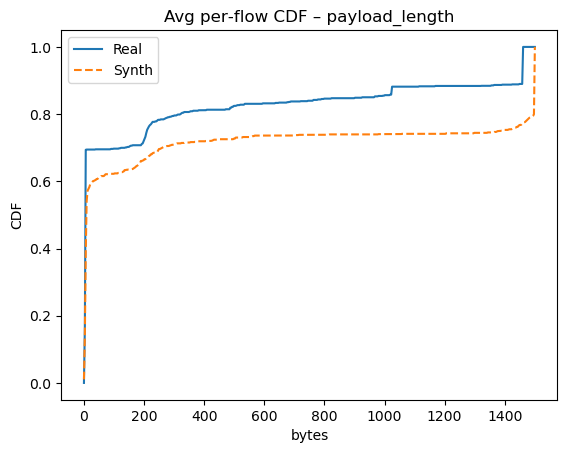

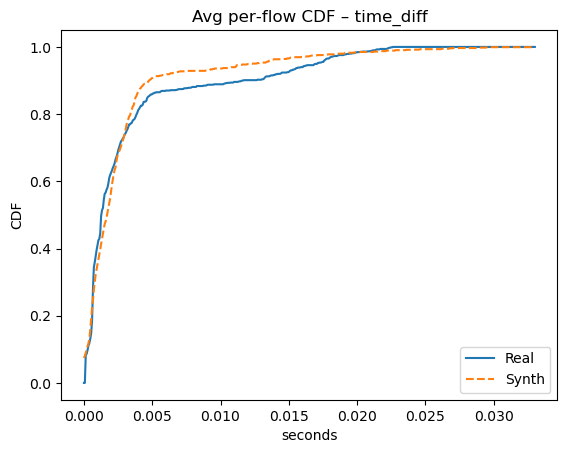

In [3]:
# ------------------------------------------------------------------ #
# 9  Sanity checks & CDF plots
# ------------------------------------------------------------------ #
stat_p, p_p = ks_2samp(test_df.payload_length, synth_df.payload_length)
stat_t, p_t = ks_2samp(test_df.time_diff,      synth_df.time_diff)
print(f"KS  payload_length: D={stat_p:.4f}  p={p_p:.4e}")
print(f"KS  time_diff     : D={stat_t:.4f}  p={p_t:.4e}")

def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)
    def cdfs(df):
        out = []
        for _, g in df.groupby("flow_id"):
            v = np.sort(g[feat].values)
            out.append(np.searchsorted(v, xs, 'right')/len(v))
        return np.stack(out)
    return xs, cdfs(rdf).mean(0), cdfs(sdf).mean(0)

x1, r1, s1 = avg_flow_cdf(test_df, synth_df, "payload_length")
x2, r2, s2 = avg_flow_cdf(test_df, synth_df, "time_diff")

plt.figure(); plt.plot(x1, r1, label="Real"); plt.plot(x1, s1, "--", label="Synth")
plt.title("Avg per‑flow CDF – payload_length"); plt.xlabel("bytes"); plt.ylabel("CDF")
plt.legend(); plt.show()

plt.figure(); plt.plot(x2, r2, label="Real"); plt.plot(x2, s2, "--", label="Synth")
plt.title("Avg per‑flow CDF – time_diff"); plt.xlabel("seconds"); plt.ylabel("CDF")
plt.legend(); plt.show()

In [4]:
# Save CDFs to CSV for later use in pgfplots or manual import

# 1) Payload-length CDF
payload_df = pd.DataFrame({
    'x':            x1,
    'real_cdf':     r1,
    'synth_cdf':    s1
})
# save for pgfplots or manual import:
#payload_df.to_csv('payload_cdf_http.csv', index=False)

# 2) Time-diff CDF
time_df = pd.DataFrame({
    'x':            x2,
    'real_cdf':     r2,
    'synth_cdf':    s2
})
#time_df.to_csv('time_cdf_http.csv', index=False)


In [ ]:
from statsmodels.tsa.stattools import acf

def seqs_by_flow(df: pd.DataFrame, col: str):
    return [g.sort_index()[col].astype(float).values
            for _, g in df.groupby("flow_id") if len(g) > 1]

def average_psd(seqs, fs: float = 1.0, nfft: int = 256):
    psds = []
    freqs = None
    for x in seqs:
        f, p = sg.welch(x, fs=fs, nperseg=min(nfft, len(x)), nfft=nfft,
                         scaling="density", detrend=False)
        psds.append(p + 1e-12)  # avoid zeros
        if freqs is None:
            freqs = f
    return freqs, np.mean(psds, axis=0)

def kl_div(p, q):
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * (entropy(p, q) + entropy(q, p))

# --- average CDF per flow ----------------------------------------------------
def avg_flow_cdf(rdf, sdf, feat, grid=500):
    lo, hi = min(rdf[feat].min(), sdf[feat].min()), \
             max(rdf[feat].max(), sdf[feat].max())
    xs = np.linspace(lo, hi, grid)

    def _flow_cdfs(df):
        mats = []
        for _, g in df.groupby('flow_id'):
            v = np.sort(g[feat].values)
            mats.append(np.searchsorted(v, xs, 'right') / len(v))
        return np.stack(mats)                 # (n_flows, grid)

    return xs, _flow_cdfs(rdf).mean(0), _flow_cdfs(sdf).mean(0)

# KL between the two *mean* CDFs (convert CDF→PDF via finite diff)
def kl_avg_flow_cdf(rdf, sdf, feat, grid=500):
    _, cdf_r, cdf_s = avg_flow_cdf(rdf, sdf, feat, grid)
    pdf_r = np.diff(cdf_r, prepend=0) + 1e-12   # avoid zeros
    pdf_s = np.diff(cdf_s, prepend=0) + 1e-12
    return kl_div(pdf_r, pdf_s)

def spectral_entropy_list(seqs, nfft: int = 256):
    ent = []
    for x in seqs:
        _, Pxx = sg.welch(x, nperseg=min(nfft, len(x)), nfft=nfft,
                          scaling="density")
        Pxx /= Pxx.sum()
        ent.append(entropy(Pxx, base=2))
    return np.asarray(ent)

def spectral_entropy_coverage(real, synth):
    def _e(v):
        _, P = sg.welch(v, nperseg=min(256, len(v)), nfft=256, scaling="density")
        P /= P.sum()
        return entropy(P, base=2)
    H_r = np.array([_e(x) for x in real])
    H_s = np.array([_e(x) for x in synth])
    cov = max(0, H_s.min() - H_r.min()) + max(0, H_r.max() - H_s.max())
    return cov / (H_r.max() - H_r.min() + 1e-12)

def mean_acf(seqs, nlags=20, fft=True):
    """
    Element-wise mean ACF over a list of 1-D sequences.

    • If a sequence is shorter than `nlags+1`, we let acf() return the
      maximum it can (len(x) lags).
    • After collecting all ACFs, we truncate every vector to the *shortest*
      length found, so we have a neat (n_flows, L) matrix.
    """
    acfs = []
    for x in seqs:
        if len(x) < 2:
            continue                      # needs at least 2 points
        L = min(nlags, len(x) - 1)
        acfs.append(acf(x, nlags=L, fft=fft))

    if not acfs:
        raise ValueError("No sequences long enough to compute ACF")

    # truncate to common length
    Lmin = min(a.size for a in acfs)
    acfs = np.stack([a[:Lmin] for a in acfs])
    return acfs.mean(axis=0)


metrics = {}
metrics["ks_payload"] = ks_2samp(test_df.payload_length, synth_df.payload_length).statistic
metrics["ks_time"]    = ks_2samp(test_df.time_diff,      synth_df.time_diff).statistic

rp, psd_r = average_psd(seqs_by_flow(test_df, "payload_length"))
_,  psd_s = average_psd(seqs_by_flow(synth_df, "payload_length"))
metrics["kl_psd_payload"] = kl_div(psd_r, psd_s)

rt, tpd_r = average_psd(seqs_by_flow(test_df, "time_diff"))
_,  tpd_s = average_psd(seqs_by_flow(synth_df, "time_diff"))
metrics["kl_psd_time"] = kl_div(tpd_r, tpd_s)

metrics['kl_cdf_payload'] = kl_avg_flow_cdf(test_df,   synth_df, 'payload_length')
metrics['kl_cdf_time']    = kl_avg_flow_cdf(test_df,   synth_df, 'time_diff')

metrics["diversity_payload"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "payload_length"), seqs_by_flow(synth_df, "payload_length"))
metrics["diversity_time"] = spectral_entropy_coverage(
    seqs_by_flow(test_df, "time_diff"), seqs_by_flow(synth_df, "time_diff"))

ent_real_pl = spectral_entropy_list(seqs_by_flow(test_df, "payload_length"))
ent_synt_pl = spectral_entropy_list(seqs_by_flow(synth_df, "payload_length"))
metrics["delta_mean_payload"] = float(abs(ent_synt_pl.mean() - ent_real_pl.mean()))

ent_real_td = spectral_entropy_list(seqs_by_flow(test_df, "time_diff"))
ent_synt_td = spectral_entropy_list(seqs_by_flow(synth_df, "time_diff"))
metrics["delta_mean_time"] = float(abs(ent_synt_td.mean() - ent_real_td.mean()))

acf_r_payload = mean_acf(seqs_by_flow(test_df,  "payload_length"))
acf_s_payload = mean_acf(seqs_by_flow(synth_df, "payload_length"))
L = min(len(acf_r_payload), len(acf_s_payload))    
metrics['acf_rmse_payload'] = np.sqrt(
    ((acf_r_payload[:L] - acf_s_payload[:L]) ** 2).mean())

acf_r_time = mean_acf(seqs_by_flow(test_df,  "time_diff"))
acf_s_time = mean_acf(seqs_by_flow(synth_df, "time_diff"))
L = min(len(acf_r_time), len(acf_s_time))
metrics['acf_rmse_time'] = np.sqrt(
    ((acf_r_time[:L] - acf_s_time[:L]) ** 2).mean())

# --- print metrics -----------------------------------------------------------
print("\n=== Metrics - HTTP ===")
for k, v in metrics.items():
    print(f"{k:<25} : {v:.4g}")


=== Metrics - HTTP ===
ks_payload                : 0.246
ks_time                   : 0.09774
kl_psd_payload            : 0.08289
kl_psd_time               : 0.03811
kl_cdf_payload            : 6.91
kl_cdf_time               : 3.35
diversity_payload         : 0.4778
diversity_time            : 0.03733
delta_mean_payload        : 0.1623
delta_mean_time           : 0.115
acf_rmse_payload          : 0.1121
acf_rmse_time             : 0.05135
